In [1]:
import import_ipynb
from data603 import HDFS

httpdfs = HDFS.get_httpdfs()
httpdfs.list('/data/keras_models')

importing Jupyter notebook from /scratch/data603/yk98337/data603/HDFS.ipynb


['densenet',
 'efficientnet',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'vgg16',
 'vgg19',
 'xception']

In [2]:
# Create a local directory
import os
keras_data = './keras_data'
if(not os.path.exists(keras_data)):
    os.mkdir(keras_data)

# download file from hdfs
vgg16_weight_file = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
local_weight_file = f"{keras_data}/{vgg16_weight_file}"
if(not os.path.exists(local_weight_file)):
    httpdfs.download(f"/data/keras_models/vgg16/{vgg16_weight_file}", local_weight_file)

# check local file exists
os.listdir(keras_data)

['vgg16_weights_tf_dim_ordering_tf_kernels.h5']

In [3]:
import import_ipynb
from data603 import SparkLauncher

# get a configuration object
conf = SparkLauncher.get_spark_conf()

# add a file to the configuration that will get copied to all the nodes on the cluster
conf.set('spark.yarn.dist.files', './keras_data/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

# launch the cluster using the configuration
spark = SparkLauncher.get_spark_session(pack_venv = False, conf = conf)

importing Jupyter notebook from /scratch/data603/yk98337/data603/SparkLauncher.ipynb
Creating Spark Configuration
Creating Spark Configuration
Setting Environment Variables
Creating Spark Session: yk98337_data603_spark_session


In [4]:
import os
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [5]:
vehicles = spark.read.parquet('/user/yk98337/vehicles.parquet')

In [6]:
v1 = vehicles.where(vehicles['Label'] == 'Airplane')

In [7]:
v1.show(3)

+----------------+---------+------------+----------+--------+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+------------+--------------------+--------------------+--------+
|         ImageID|LabelName|      Source|Confidence|   Label|Subset|Format|                Data|         OriginalURL|  OriginalLandingURL|             License|    AuthorProfileURL|         Author|               Title|OriginalSize|         OriginalMD5|    Thumbnail300KURL|Rotation|
+----------------+---------+------------+----------+--------+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+------------+--------------------+--------------------+--------+
|0000dc465ec144aa| /m/0cmf2|verification|         0|Airplane| train|   JPG|[FF D8 FF E0 00 1...|https://c3.static...|https://www.flick...|https://creative

In [13]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential

In [16]:
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, GlobalAveragePooling2D

In [17]:
model = VGG16(weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [18]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [19]:
k = v1.limit(3).toPandas()

In [20]:
k.columns

Index(['ImageID', 'LabelName', 'Source', 'Confidence', 'Label', 'Subset',
       'Format', 'Data', 'OriginalURL', 'OriginalLandingURL', 'License',
       'AuthorProfileURL', 'Author', 'Title', 'OriginalSize', 'OriginalMD5',
       'Thumbnail300KURL', 'Rotation'],
      dtype='object')

In [21]:
import io
img = io.BytesIO(k['Data'][0])
img = load_img(img, target_size=(224,224))

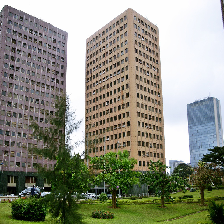

In [22]:
img

In [23]:
import numpy as np
image = img_to_array(img)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)
features = model.predict(image)

In [30]:
features.shape

(1, 7, 7, 512)

In [25]:
features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))

In [32]:
features_flatten.shape

(1, 25088)

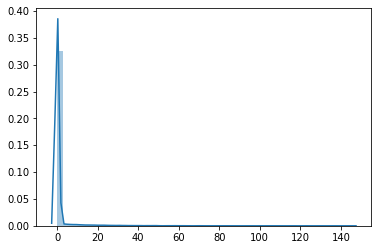

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(features_flatten[0])

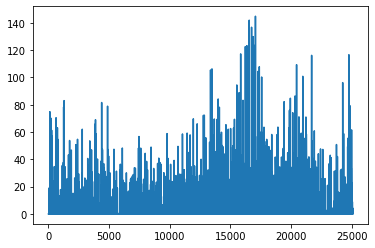

In [40]:
plt.plot(features_flatten[0])

In [41]:
np.argmax(features_flatten)

17064

In [46]:
k1 = v1.limit(1)
a = k1.collect()

In [54]:

def evaluate_features(data):
    img = io.BytesIO(data)
    img = load_img(img, target_size=(224,224))
    image = img_to_array(img)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)
    features = model.predict(image)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return np.argmax(features_flatten)

In [60]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
udf_evaluate_features = udf()
v2 = v1.withColumn('preds',evaluate_features(col('Data')))

NameError: name 'col' is not defined

In [59]:
v1.schema

StructType(List(StructField(ImageID,StringType,true),StructField(LabelName,StringType,true),StructField(Source,StringType,true),StructField(Confidence,StringType,true),StructField(Label,StringType,true),StructField(Subset,StringType,true),StructField(Format,StringType,true),StructField(Data,BinaryType,true),StructField(OriginalURL,StringType,true),StructField(OriginalLandingURL,StringType,true),StructField(License,StringType,true),StructField(AuthorProfileURL,StringType,true),StructField(Author,StringType,true),StructField(Title,StringType,true),StructField(OriginalSize,StringType,true),StructField(OriginalMD5,StringType,true),StructField(Thumbnail300KURL,StringType,true),StructField(Rotation,StringType,true)))

In [65]:
from pyspark.sql.types import IntegerType, BinaryType
from pyspark.sql.functions import udf
udf_evaluate_features = udf(evaluate_features, IntegerType())
v2 = v1.withColumn('preds',udf_evaluate_features('Data'))

Traceback (most recent call last):
  File "/scratch/data603_virtualenv/yk98337/lib64/python3.6/site-packages/pyspark/serializers.py", line 597, in dumps
    return cloudpickle.dumps(obj, 2)
  File "/scratch/data603_virtualenv/yk98337/lib64/python3.6/site-packages/pyspark/cloudpickle.py", line 863, in dumps
    cp.dump(obj)
  File "/scratch/data603_virtualenv/yk98337/lib64/python3.6/site-packages/pyspark/cloudpickle.py", line 260, in dump
    return Pickler.dump(self, obj)
  File "/usr/lib64/python3.6/pickle.py", line 409, in dump
    self.save(obj)
  File "/usr/lib64/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/usr/lib64/python3.6/pickle.py", line 736, in save_tuple
    save(element)
  File "/usr/lib64/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/scratch/data603_virtualenv/yk98337/lib64/python3.6/site-packages/pyspark/cloudpickle.py", line 400, in save_function
  

PicklingError: Could not serialize object: TypeError: can't pickle _thread.RLock objects

In [66]:
v2 = v1.limit(1).drop('Data')

In [64]:
v2.collect()

[Row(ImageID='0000dc465ec144aa', LabelName='/m/0cmf2', Source='verification', Confidence='0', Label='Airplane', Subset='train', Format='JPG', OriginalURL='https://c3.staticflickr.com/2/1022/4599688756_7a03038486_o.jpg', OriginalLandingURL='https://www.flickr.com/photos/willstephe/4599688756', License='https://creativecommons.org/licenses/by/2.0/', AuthorProfileURL='https://www.flickr.com/people/willstephe/', Author='Willstephe Vaho', Title='Cité administrative', OriginalSize='2030745', OriginalMD5='Nv+EieQq7hvbOqGQYLH3Sw==', Thumbnail300KURL='https://c7.staticflickr.com/2/1022/4599688756_bf8643e069_z.jpg', Rotation='0.0')]

In [70]:
preds = v1.select("Data").flatMap(lambda x: evaluate_features(x))

AttributeError: 'DataFrame' object has no attribute 'flatMap'

In [71]:
for i in v1.select('Label').limit(3):
    print(i)

Column<b'Label'>


In [72]:
spark.stop()